## This project uses the Chest X-Ray image dataset provided at https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia/

# REQUIRED IMPORTS

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import keras
from keras import layers
from keras.callbacks import ModelCheckpoint
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB1 # Expects 240 resolution (divisble by 8 and 16 to prevent zero-padding near boundaries)

from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.pipeline import Pipeline

# CONSTANTS

In [4]:
BATCH_SIZE = 32
EPOCHS = 40
IMAGE_SIZE = 240
CHANNELS = 3
INPUT_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
NUM_CLASSES = 2

# LOAD DATA
## Import Train, Test and Validation Datasets

In [5]:
# Load train, test and val datasets
train, val = keras.utils.image_dataset_from_directory(
    "data/train",
    validation_split=0.2,
    subset="both",
    seed=42,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="binary"
)

test = keras.utils.image_dataset_from_directory(
    "data/test",
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="binary"
)

Found 5219 files belonging to 2 classes.
Using 4176 files for training.
Using 1043 files for validation.
Found 624 files belonging to 2 classes.


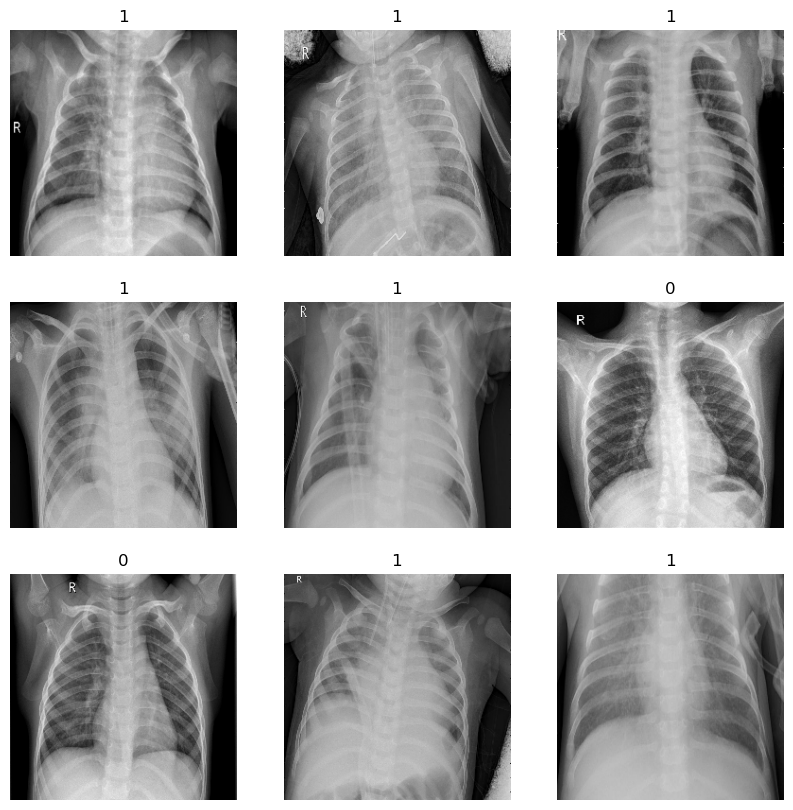

In [6]:
# Display image samples
plt.figure(figsize=(10, 10))
for images, labels in train.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype(int))
        plt.title(int(labels[i]))
        plt.axis("off")


# PREPROCESS DATA
## Check data distribution for imbalance

In [7]:
label_counts = {0: 0, 1: 0}
for image, label in train:
    for tensor in np.array(label).astype(int):
        label_counts[tensor[0]] += 1

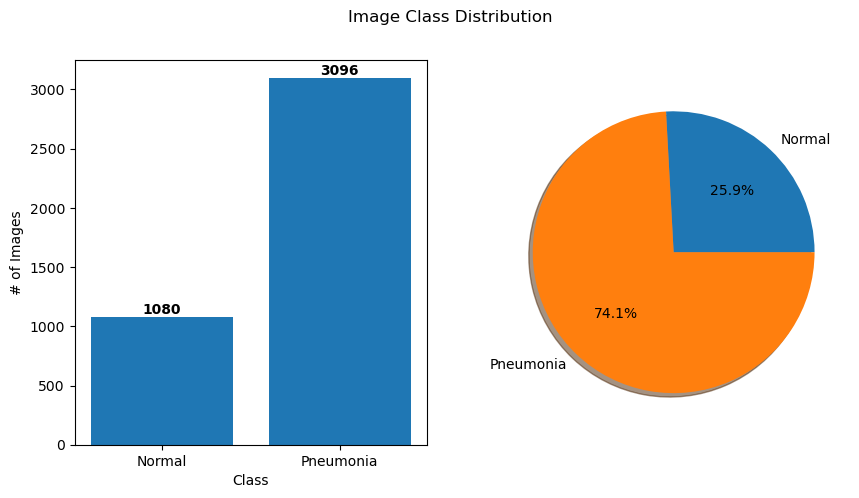

In [8]:
label_counts = {0: 0, 1: 0}
for _, label in train:
    for tensor in np.array(label).astype(int):
        label_counts[tensor[0]] += 1
        
x = list(label_counts.keys())
y = list(label_counts.values())
x_labels = ["Normal", "Pneumonia"]

# Display distribution of images with pyplot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Image Class Distribution')

ax1.bar(x,y)
ax1.set_xticks(x)
ax1.set_xticklabels(x_labels)
ax1.set_ylabel('# of Images')
ax1.set_xlabel('Class')

for i, v in enumerate(y):
    ax1.text(i, v + 1, str(v), ha='center', va='bottom', fontweight='bold')


ax2.pie(y , labels=x_labels, autopct='%1.1f%%', shadow = True)
                    
plt.show() 

## Compute class weights to assign more weight to minority class

In [9]:
# Collect labels from train set and use them to compute adjusted class weights
all_labels = []
for _, labels in train:
    all_labels.extend(labels.numpy())

y_train = np.concatenate(all_labels, axis=0).astype(int)

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

train_class_weights = dict(enumerate(class_weights))

## Apply image augmentation

In [10]:
# Apply data augmentation to increase size of dataset and reduce chance of overfitting
augmented_data_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomFlip("vertical"),
    layers.RandomRotation(0.2),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    layers.RandomContrast(0.2)
]

def augment_images(images, labels):
    for layer in augmented_data_layers:
        images = layer(images)
    return images, labels

In [11]:
# Apply augmentation to training set and prefetch data fro faster training
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train.map(augment_images, num_parallel_calls=AUTOTUNE)

train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val.cache().prefetch(AUTOTUNE)

# CONSTRUCT MODELS
## Build the CNN-based classifier using the Keras Functional API

In [12]:
# Constructor for CNN-based image classifier
def build_cnn_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    x = layers.Rescaling(1.0 / 255)(inputs)

    filter_sizes = [16, 32, 64, 128]
    for size in filter_sizes:
        x = layers.Conv2D(filters=size, kernel_size=3, activation = 'relu', padding="same")(x)
        x = layers.BatchNormalization()(x)
        if size == filter_sizes[-1]:
            x = layers.GlobalAveragePooling2D()(x)
        else:
            x = layers.MaxPooling2D(pool_size=2, strides=2, padding="same")(x)
        x = layers.Dropout(0.2)(x)
    
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.4)(x)

    if num_classes == 2:
        outputs = layers.Dense(1, activation='sigmoid')(x)
    else:
        outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    return keras.Model(inputs, outputs)

In [13]:
model = build_cnn_model(input_shape=INPUT_SHAPE, num_classes=NUM_CLASSES)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[keras.metrics.BinaryAccuracy(name="acc"), keras.metrics.Precision(name="prec"), keras.metrics.Recall(name="recall")],
)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 240, 240, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 240, 240, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 240, 240, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 240, 240, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 120, 120, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 120, 120, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 120, 120, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 120, 120, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 60, 60, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 60, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 60, 60, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 30, 30, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 30, 30, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 123,233 (481.38 KB)

 Trainable params: 122,753 (479.50 KB)

 Non-trainable params: 480 (1.88 KB)

In [15]:
# Fit model against training data and save its history for analysis
cnn_filepath = "cnn_model.epoch{epoch:02d}-loss{val_loss:.2f}.keras"

# Configure ModelCheckpoint callback to keep best epoch
checkpoint_callback = ModelCheckpoint(
    filepath=cnn_filepath,
    monitor='val_loss',
    verbose=0,   
    save_best_only=True,
    mode='min',
    save_weights_only=False
)

history = model.fit(
    train_ds,
    epochs=EPOCHS,
    class_weight=train_class_weights,
    validation_data=val_ds,
    callbacks=[checkpoint_callback]
)

Epoch 1/40
131/131 ━━━━━━━━━━━━━━━━━━━━ 58s 413ms/step - acc: 0.7445 - loss: 0.5174 - prec: 0.9290 - recall: 0.7096 - val_acc: 0.7498 - val_loss: 1.3481 - val_prec: 0.7498 - val_recall: 1.0000
Epoch 2/40
131/131 ━━━━━━━━━━━━━━━━━━━━ 48s 369ms/step - acc: 0.8446 - loss: 0.3702 - prec: 0.9654 - recall: 0.8198 - val_acc: 0.7498 - val_loss: 2.2219 - val_prec: 0.7498 - val_recall: 1.0000
Epoch 3/40
131/131 ━━━━━━━━━━━━━━━━━━━━ 49s 371ms/step - acc: 0.8575 - loss: 0.3415 - prec: 0.9644 - recall: 0.8388 - val_acc: 0.7498 - val_loss: 2.2219 - val_prec: 0.7498 - val_recall: 1.0000
Epoch 4/40
131/131 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - acc: 0.8623 - loss: 0.3206 - prec: 0.9688 - recall: 0.8414 - val_acc: 0.7498 - val_loss: 1.5742 - val_prec: 0.7498 - val_recall: 1.0000
Epoch 5/40
131/131 ━━━━━━━━━━━━━━━━━━━━ 49s 372ms/step - acc: 0.8657 - loss: 0.3184 - prec: 0.9689 - recall: 0.8459 - val_acc: 0.7498 - val_loss: 1.0904 - val_prec: 0.7498 - val_recall: 1.0000
Epoch 6/40
131/131 ━━━━━━━━━━━━━━━━

## Construct EfficientNetB1 model

In [14]:
base_enb1_model = EfficientNetB1(include_top=True, weights=None, input_shape=INPUT_SHAPE)
x = base_enb1_model.output
outputs = layers.Dense(1, activation='sigmoid')(x) # Layer needed for binary classification
enb1_model = Model(inputs=base_enb1_model.input, outputs=outputs)

enb1_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[keras.metrics.BinaryAccuracy(name="acc"), keras.metrics.Precision(name="prec"), keras.metrics.Recall(name="recall")],
)

enb1_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 240, 240,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 240, 240,  │          0 │ input_layer_1[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 240, 240,  │          7 │ rescaling_1[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 241, 241,  │          0 │ normalization[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 120, 120,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 120, 120,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 120, 120,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 120, 120,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 120, 120,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 120, 120,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 120, 120,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 120, 120,  │        512 │ block1a_se_excit… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 120, 120,  │         64 │ block1a_project_

 Total params: 7,857,240 (29.97 MB)

 Trainable params: 7,795,185 (29.74 MB)

 Non-trainable params: 62,055 (242.41 KB)

In [15]:
enb1_filepath = "EfficientNetB1_model.epoch{epoch:02d}-loss{val_loss:.2f}.keras"

enb1_checkpoint_callback = ModelCheckpoint(
    filepath=enb1_filepath,
    monitor='val_loss',
    verbose=0,   
    save_best_only=True,
    mode='min',
    save_weights_only=False
)

enb1_history = enb1_model.fit(
    train_ds,
    epochs=EPOCHS,
    class_weight=train_class_weights,
    validation_data=val_ds,
    callbacks=[enb1_checkpoint_callback]
)

Epoch 1/40
131/131 ━━━━━━━━━━━━━━━━━━━━ 364s 3s/step - acc: 0.7538 - loss: 0.6802 - prec: 0.9200 - recall: 0.7316 - val_acc: 0.7498 - val_loss: 0.6718 - val_prec: 0.7498 - val_recall: 1.0000
Epoch 2/40
131/131 ━━━━━━━━━━━━━━━━━━━━ 335s 3s/step - acc: 0.8307 - loss: 0.6575 - prec: 0.9621 - recall: 0.8033 - val_acc: 0.7498 - val_loss: 0.6642 - val_prec: 0.7498 - val_recall: 1.0000
Epoch 3/40
131/131 ━━━━━━━━━━━━━━━━━━━━ 394s 3s/step - acc: 0.8599 - loss: 0.6468 - prec: 0.9648 - recall: 0.8417 - val_acc: 0.7498 - val_loss: 0.6587 - val_prec: 0.7498 - val_recall: 1.0000
Epoch 4/40
131/131 ━━━━━━━━━━━━━━━━━━━━ 343s 3s/step - acc: 0.8728 - loss: 0.6389 - prec: 0.9717 - recall: 0.8534 - val_acc: 0.8878 - val_loss: 0.6338 - val_prec: 0.9279 - val_recall: 0.9220
Epoch 5/40
131/131 ━━━━━━━━━━━━━━━━━━━━ 343s 3s/step - acc: 0.8786 - loss: 0.6336 - prec: 0.9658 - recall: 0.8669 - val_acc: 0.8802 - val_loss: 0.6295 - val_prec: 0.9544 - val_recall: 0.8824
Epoch 6/40
131/131 ━━━━━━━━━━━━━━━━━━━━ 338s 

# EVALUATE MODEL PERFORMANCE

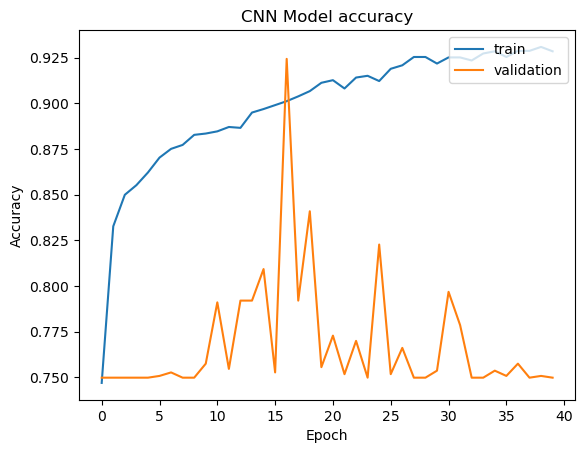

In [16]:
# Plot CNN accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('CNN Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show() 

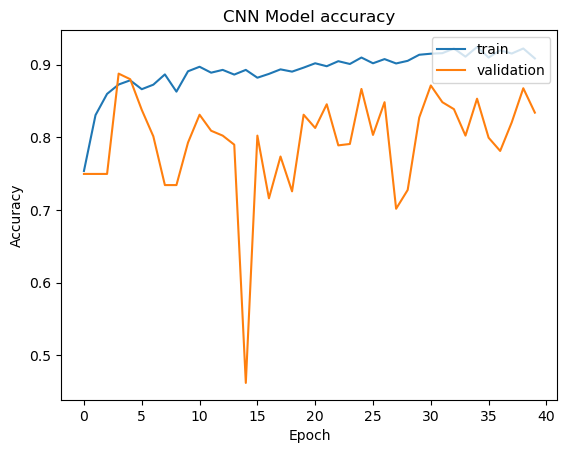

In [17]:
# Plot EfficientNetB1 accuracy
plt.plot(enb1_history.history['acc'])
plt.plot(enb1_history.history['val_acc'])
plt.title('CNN Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show() 

In [18]:
model.evaluate(test)

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - acc: 0.6250 - loss: 3.9083 - prec: 0.6250 - recall: 1.0000 


[3.908320903778076, 0.625, 0.625, 1.0]

In [19]:
enb1_model.evaluate(test)

20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 400ms/step - acc: 0.8301 - loss: 0.5374 - prec: 0.8901 - recall: 0.8308


[0.5373897552490234,
 0.8301281929016113,
 0.8901098966598511,
 0.8307692408561707]